In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# https://github.com/oldmonkABA/optimal_histogram_bin_width
def hist_optimize_bins(data):
    data_max = max(data) #lower end of data
    data_min = min(data) #upper end of data
    n_min = 2   #Minimum number of bins Ideal value = 2
    n_max = 200  #Maximum number of bins  Ideal value =200
    n_shift = 30     #number of shifts Ideal value = 30
    N = np.array(range(n_min,n_max))
    D = float(data_max-data_min)/N    #Bin width vector
    Cs = np.zeros((len(D),n_shift)) #Cost function vector
    #Computation of the cost function
    for i in range(np.size(N)):
        shift = np.linspace(0,D[i],n_shift)
        for j in range(n_shift):
            edges = np.linspace(data_min+shift[j]-D[i]/2,data_max+shift[j]-D[i]/2,N[i]+1) # shift the Bin edges
            binindex = np.digitize(data,edges) #Find binindex of each data point
            ki=np.bincount(binindex)[1:N[i]+1] #Find number of points in each bin
            k = np.mean(ki) #Mean of event count
            v = sum((ki-k)**2)/N[i] #Variance of event count
            Cs[i,j]+= (2*k-v)/((D[i])**2) #The cost Function

    C=Cs.mean(1)

    #Optimal Bin Size Selection
    cmin = C.min()
    idx  = np.where(C==cmin)
    idx = idx[0][0]
    Optimal_Bin_Number = N[idx]
    # Optimal_Bin_Width =  D[idx]

    return Optimal_Bin_Number

In [ ]:
import socket
def get_Host_name_IP():
    try:
        host_name = socket.gethostname()
        host_ip = socket.gethostbyname(host_name)
        print("Hostname :  ",host_name)
        print("IP : ",host_ip)
    except:
        print("Unable to get Hostname and IP")

get_Host_name_IP()

Hostname :   ecccf9233c9b
IP :  172.28.0.12


In [ ]:
import platform
system_conf = platform.uname()
print("Computer Config")
print(f"System: {system_conf.system}")
print(f"Node Name: {system_conf.node}")
print(f"Release: {system_conf.release}")
print(f"Version: {system_conf.version}")
print(f"Machine: {system_conf.machine}")
print(f"Processor: {system_conf.processor}")

Computer Config
System: Linux
Node Name: ecccf9233c9b
Release: 6.1.58+
Version: #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
Machine: x86_64
Processor: x86_64


In [ ]:
# Google Collab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pwd

'/content'

Ratings Dataset Preprocessing

In [34]:
rating_df = pd.read_csv('/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/updated_ratings_cleaned.csv')

In [35]:
rating_df.shape

(31284030, 3)

In [36]:
rating_df.head(10)

,user_id,anime_id,my_score
0,2255153,21,9
1,2255153,59,7
2,2255153,74,7
3,2255153,120,7
4,2255153,178,7
5,2255153,210,7
6,2255153,232,6
7,2255153,233,6
8,2255153,249,8
9,2255153,269,10


In [ ]:
rating_df = rating_df.dropna()

In [ ]:
rating_df.shape

(31284030, 3)

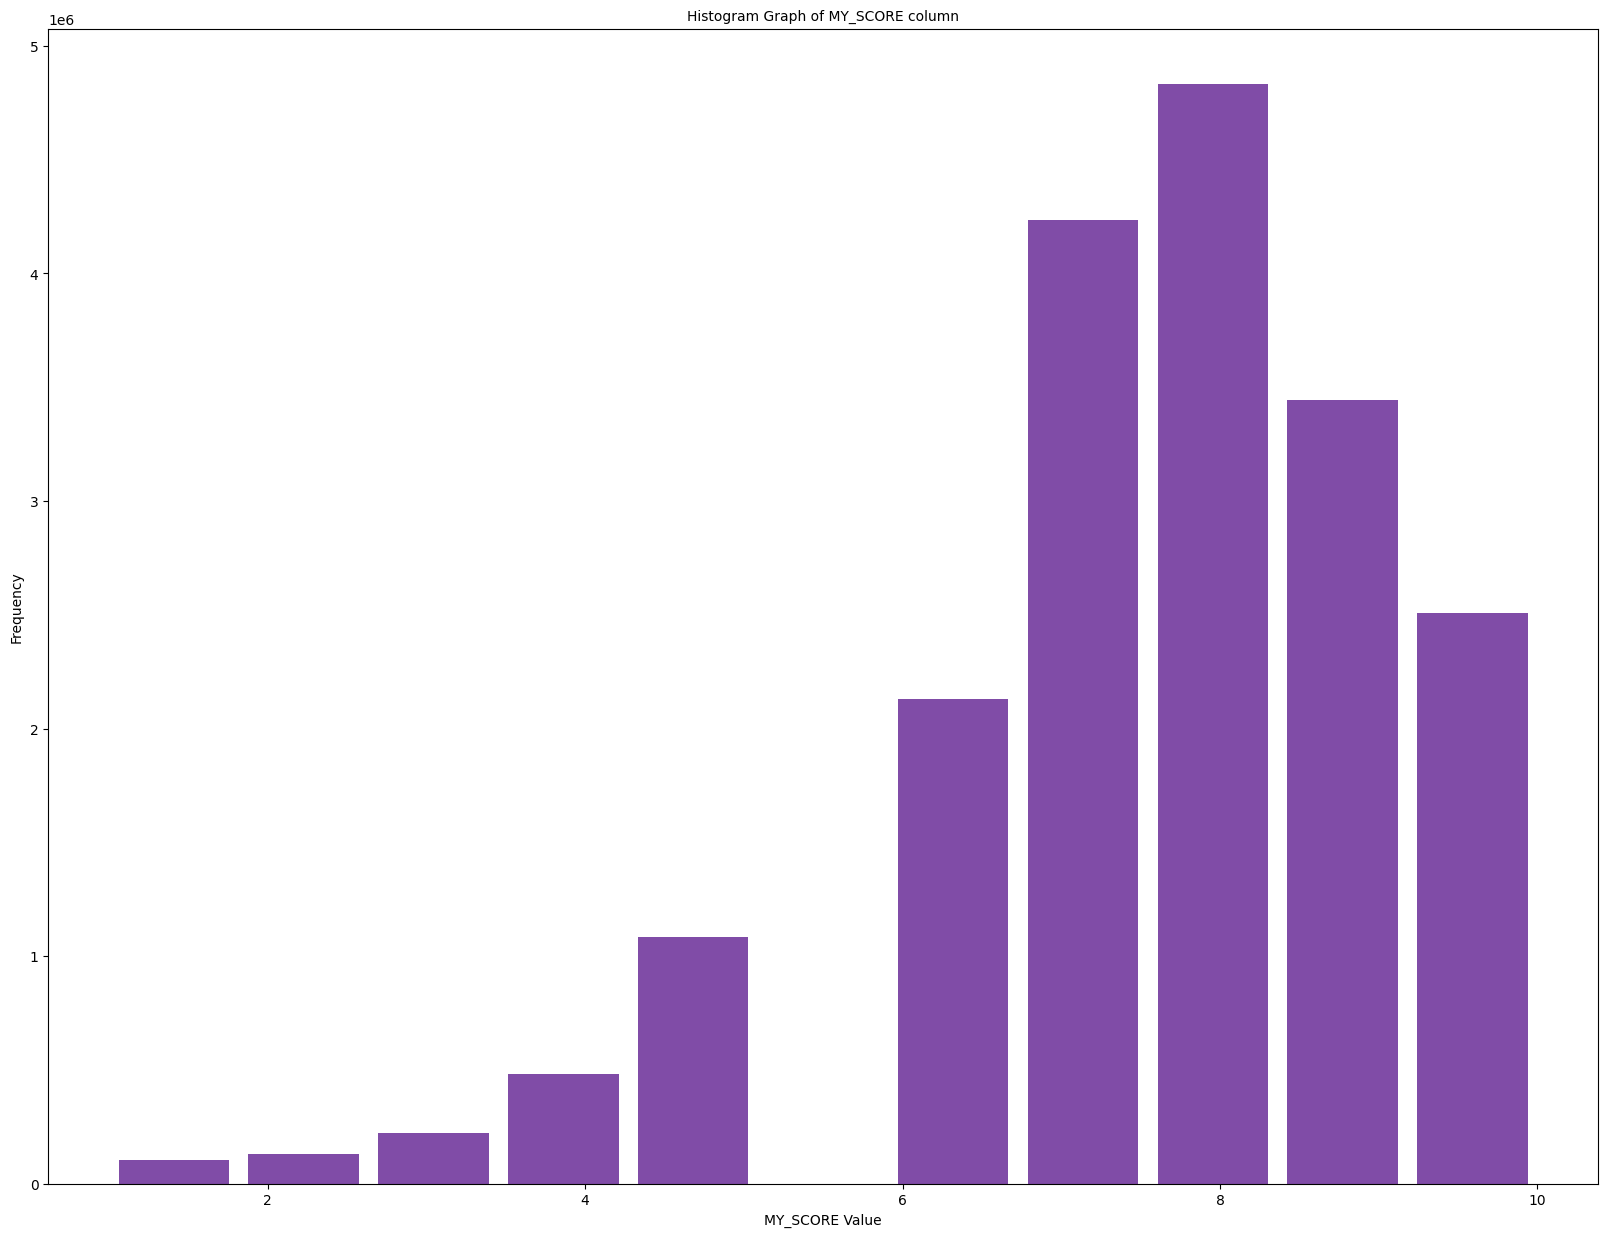

In [ ]:
data = rating_df['my_score']
col = 'my_score'
plt.figure(figsize=(20, 15))
plt.hist(data, bins=11, alpha=0.7, rwidth=0.85, color='indigo')
plt.xticks(rotation=0)
plt.title('Histogram Graph of '+col.upper()+' column',fontsize=10)
plt.xlabel(col.upper()+' Value',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
# Saving the figure in local memory
plt.savefig('/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/rating_with_0.png')

In [ ]:
rating_df = rating_df[rating_df.my_score != 0.0]

In [ ]:
rating_df.shape

(19172125, 3)

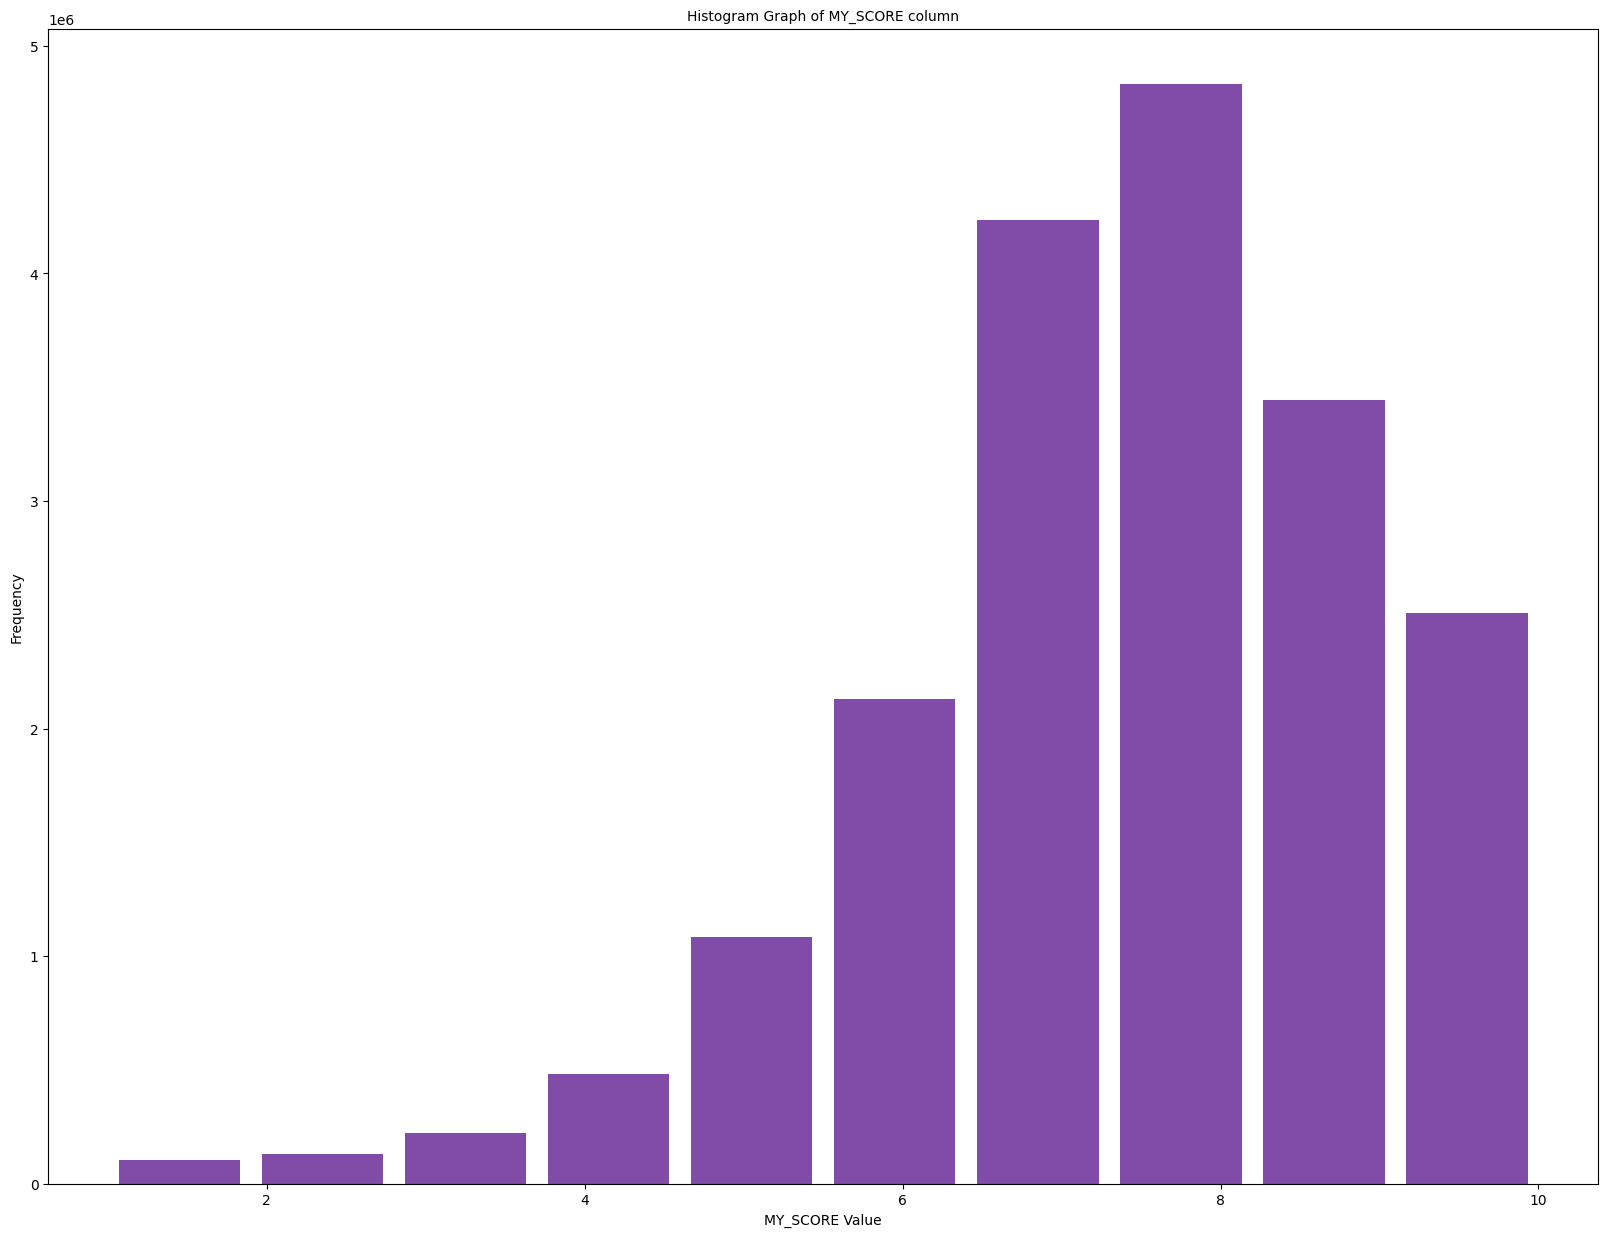

In [ ]:
data = rating_df['my_score']
col = 'my_score'
plt.figure(figsize=(20, 15))
plt.hist(data, bins=10, alpha=0.7, rwidth=0.85, color='indigo')
plt.xticks(rotation=0)
plt.title('Histogram Graph of '+col.upper()+' column',fontsize=10)
plt.xlabel(col.upper()+' Value',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
# Saving the figure in local memory
plt.savefig('/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/Rating_without_zero.png')

In [ ]:
usernames_with_ratingCounts = dict(rating_df['user_id'].value_counts())

In [ ]:
len(usernames_with_ratingCounts)

106402

In [ ]:
max_rating_count = max(usernames_with_ratingCounts.values())
max_rating_count

3785

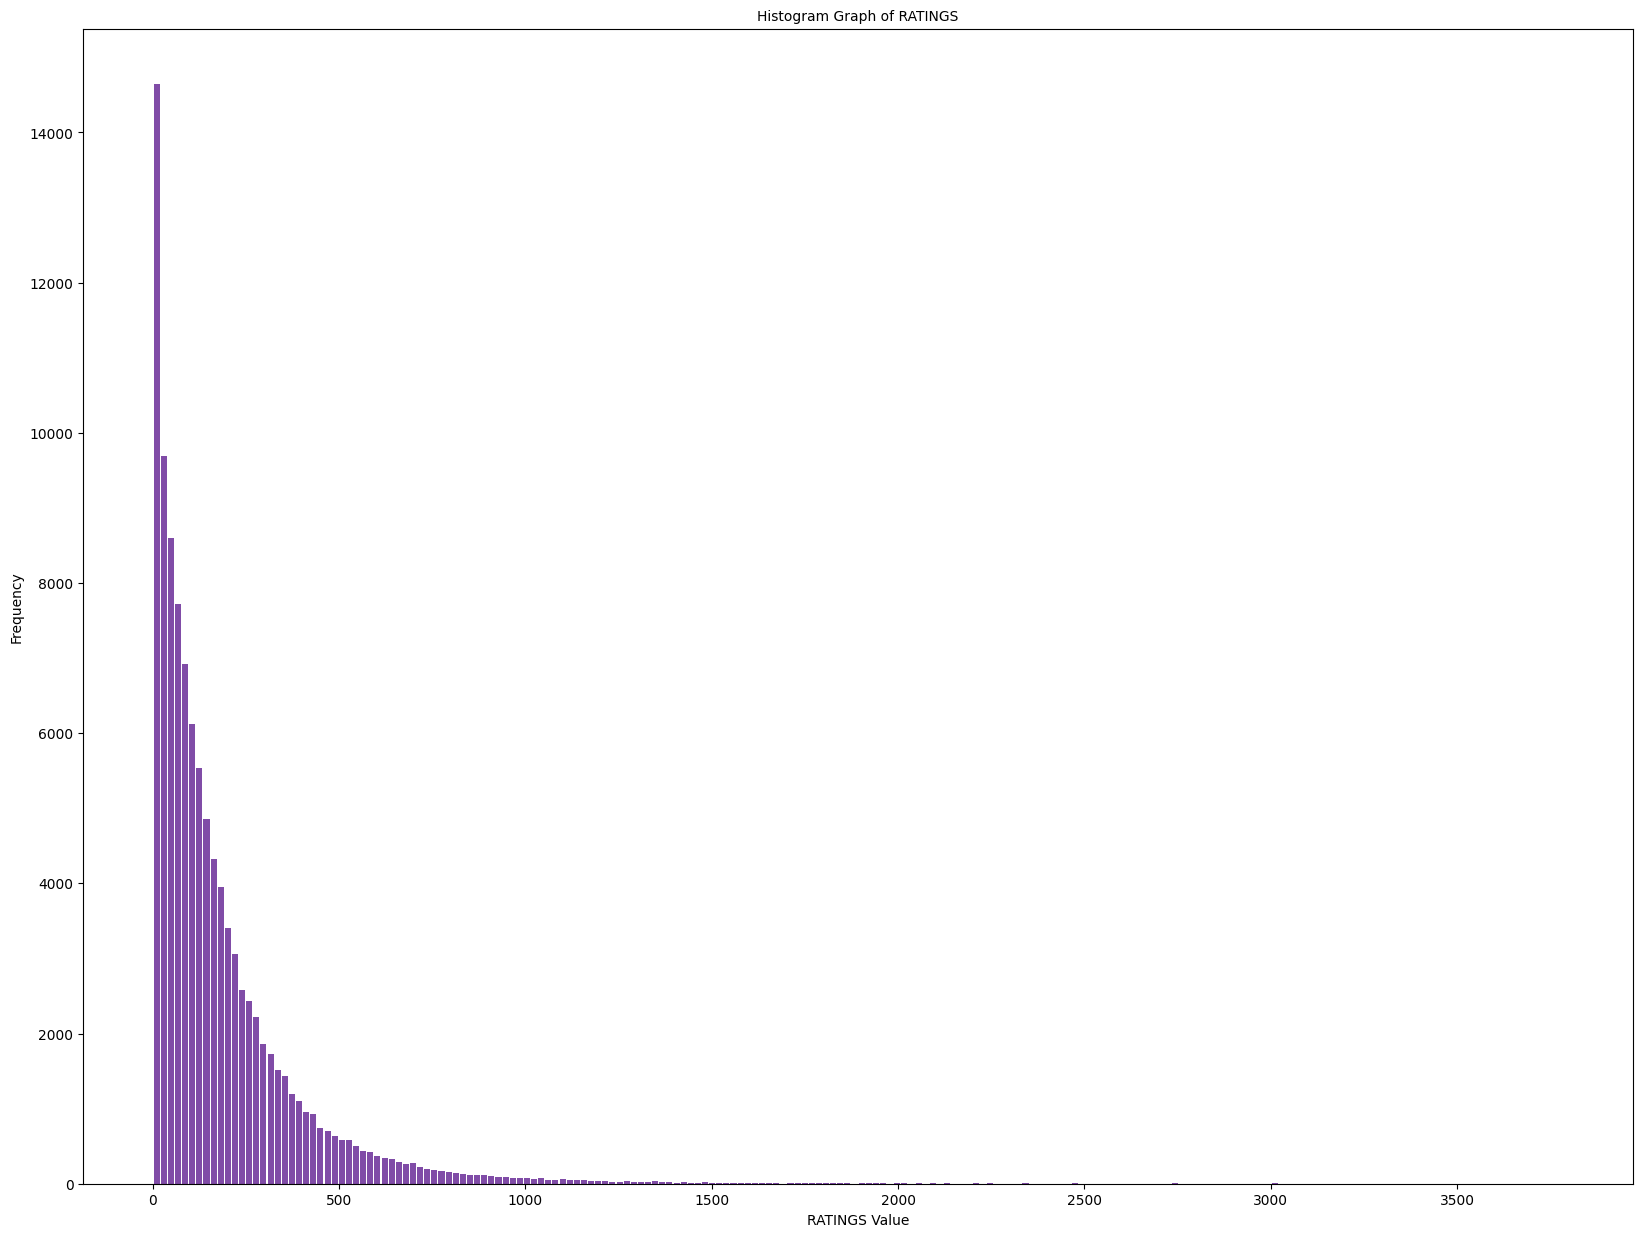

In [ ]:
data = list(usernames_with_ratingCounts.values())
col = 'ratings'
plt.figure(figsize=(20, 15))
plt.hist(data, bins=hist_optimize_bins(data), alpha=0.7, rwidth=0.85, color='indigo')
plt.xticks(rotation=0)
plt.title('Histogram Graph of '+col.upper(),fontsize=10)
plt.xlabel(col.upper()+' Value',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
# Saving the figure in local memory
plt.savefig('/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/rating_overall.png')

In [ ]:
usernames_in_rating_dataset = dict(filter(lambda elem: 1000 < elem[1] <= max_rating_count, usernames_with_ratingCounts.items()))

In [ ]:
len(usernames_in_rating_dataset)

1128

In [ ]:
rating_df = rating_df[rating_df.user_id.isin(usernames_in_rating_dataset.keys())]

In [ ]:
rating_df.shape

(1518226, 3)

In [ ]:
rating_df.head(10)

,user_id,anime_id,my_score
1201,2485327,59,6
1202,2485327,74,7
1203,2485327,120,8
1204,2485327,178,5
1205,2485327,210,7
1206,2485327,232,9
1207,2485327,249,7
1208,2485327,269,8
1210,2485327,853,9
1211,2485327,857,7


Identifying users in the Rating Dataset

In [ ]:
usernames_in_rating = list(usernames_with_ratingCounts.keys())

In [ ]:
# userIds
usernames_in_rating[0:3]

[221755, 3007063, 123582]

Identifying animes in the Rating Dataset

In [ ]:
animes_with_ratingCounts = dict(rating_df['anime_id'].value_counts())

In [ ]:
animes_in_rating = list(animes_with_ratingCounts.keys())

In [ ]:
animes_in_rating[0:3]

[6547, 11757, 4224]

User Dataset Preprocessing

In [28]:
user_df = pd.read_csv('/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/updated_users_cleaned.csv',
                      usecols=['username', 'user_id', 'gender', 'location', 'age'])

In [29]:
user_df.shape

(108705, 5)

In [30]:
user_df.head(10)

,username,user_id,gender,location,age
0,karthiga,2255153,Female,"Chennai, India",33
1,Damonashu,37326,Male,"Detroit,Michigan",32
2,bskai,228342,Male,"Nayarit, Mexico",33
3,terune_uzumaki,327311,Female,"Malaysia, Kuantan",25
4,Bas_G,5015094,Male,"Nijmegen, Nederland",24
5,HimeAria,3129315,Female,Poland,27
6,Skallington,326733,Male,Norberg Sweden,33
7,Slimak,61677,Male,Poland,36
8,Elysiun,5927342,Male,Nebraska,39
9,jimothy000,47167,Male,"England,Manchester",29


In [37]:
rating_df.head()

,user_id,anime_id,my_score
0,2255153,21,9
1,2255153,59,7
2,2255153,74,7
3,2255153,120,7
4,2255153,178,7


In [38]:
# Merging both DataFrames based on user_id
combined_df = pd.merge(user_df, rating_df, on='user_id')

combined_df.head()

,username,user_id,gender,location,age,anime_id,my_score
0,karthiga,2255153,Female,"Chennai, India",33,21,9
1,karthiga,2255153,Female,"Chennai, India",33,59,7
2,karthiga,2255153,Female,"Chennai, India",33,74,7
3,karthiga,2255153,Female,"Chennai, India",33,120,7
4,karthiga,2255153,Female,"Chennai, India",33,178,7


In [40]:
users_with_names = dict(zip(combined_df.user_id,combined_df.username))

In [41]:
users_with_names[28563]

'Zenit'

In [53]:
users_with_IDs = dict(zip(combined_df.username, combined_df.user_id))

In [54]:
users_with_IDs['Zenit']

28563

In [ ]:
def userid_to_username(userid):
    return users_with_IDs[userid]

In [ ]:
rating_df['username'] = rating_df["user_id"].apply(userid_to_username)

In [ ]:
#rating_df = rating_df.rename(columns={'username': 'user_id'})

In [ ]:
rating_df.head(10)

,user_id,anime_id,my_score,username
1201,2485327,59,6,MistButterfly
1202,2485327,74,7,MistButterfly
1203,2485327,120,8,MistButterfly
1204,2485327,178,5,MistButterfly
1205,2485327,210,7,MistButterfly
1206,2485327,232,9,MistButterfly
1207,2485327,249,7,MistButterfly
1208,2485327,269,8,MistButterfly
1210,2485327,853,9,MistButterfly
1211,2485327,857,7,MistButterfly


In [ ]:
#rating_df.to_csv('./preprocessed_data/rating.csv', encoding='utf-8', index=False)

Anime List Dataset

In [ ]:
anime_df = pd.read_csv('/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/updated_anime_cleaned.csv', usecols=['anime_id','title', 'image_url', 'genre', 'aired_from_year'])

In [ ]:
anime_df["genre"] = anime_df["genre"].fillna('NULL')

In [ ]:
anime_df.shape

(6668, 5)

In [ ]:
anime_df.head(10)

,anime_id,title,image_url,genre,aired_from_year
0,11013,Inu x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Supernatural, Romance, Shounen",2012.0
1,2104,Seto no Hanayome,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Parody, Romance, School, Shounen",2007.0
2,5262,Shugo Chara!! Doki,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Magic, School, Shoujo",2008.0
3,721,Princess Tutu,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Drama, Magic, Romance, Fantasy",2002.0
4,12365,Bakuman. 3rd Season,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Drama, Romance, Shounen",2012.0
5,6586,Yume-iro Pâtissière,https://myanimelist.cdn-dena.com/images/anime/...,"Kids, School, Shoujo",2009.0
6,178,Ultra Maniac,https://myanimelist.cdn-dena.com/images/anime/...,"Magic, Comedy, Romance, School, Shoujo",2003.0
7,2787,Shakugan no Shana II (Second),https://myanimelist.cdn-dena.com/images/anime/...,"Action, Drama, Fantasy, Romance, School, Super...",2007.0
8,4477,Nodame Cantabile: Paris-hen,https://myanimelist.cdn-dena.com/images/anime/...,"Music, Slice of Life, Comedy, Romance, Josei",2008.0
9,853,Ouran Koukou Host Club,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Harem, Romance, School, Shoujo",2006.0


Dropping animes not in the preprocessed rating dataset

In [ ]:
anime_df = anime_df[anime_df.anime_id.isin(animes_in_rating)]

In [ ]:
anime_df.shape

(6562, 5)

In [ ]:
anime_df.head(10)

,anime_id,title,image_url,genre,aired_from_year
0,11013,Inu x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Supernatural, Romance, Shounen",2012.0
1,2104,Seto no Hanayome,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Parody, Romance, School, Shounen",2007.0
2,5262,Shugo Chara!! Doki,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Magic, School, Shoujo",2008.0
3,721,Princess Tutu,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Drama, Magic, Romance, Fantasy",2002.0
4,12365,Bakuman. 3rd Season,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Drama, Romance, Shounen",2012.0
5,6586,Yume-iro Pâtissière,https://myanimelist.cdn-dena.com/images/anime/...,"Kids, School, Shoujo",2009.0
6,178,Ultra Maniac,https://myanimelist.cdn-dena.com/images/anime/...,"Magic, Comedy, Romance, School, Shoujo",2003.0
7,2787,Shakugan no Shana II (Second),https://myanimelist.cdn-dena.com/images/anime/...,"Action, Drama, Fantasy, Romance, School, Super...",2007.0
8,4477,Nodame Cantabile: Paris-hen,https://myanimelist.cdn-dena.com/images/anime/...,"Music, Slice of Life, Comedy, Romance, Josei",2008.0
9,853,Ouran Koukou Host Club,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Harem, Romance, School, Shoujo",2006.0


In [ ]:
anime_genre= anime_df["genre"].str.split(', ').tolist()
anime_genre[0:3]

[['Comedy', 'Supernatural', 'Romance', 'Shounen'],
 ['Comedy', 'Parody', 'Romance', 'School', 'Shounen'],
 ['Comedy', 'Magic', 'School', 'Shoujo']]

In [ ]:
import itertools
# list, 2D to 1D
genre_all_rows_values = list(itertools.chain.from_iterable(anime_genre))

In [ ]:
len(genre_all_rows_values)

23525

In [ ]:
genres = list(set(genre_all_rows_values))
len(genres)

44

In [ ]:
genres[0:3]

['Martial Arts', 'Samurai', 'Game']

In [ ]:
anime_df = anime_df.reindex(anime_df.columns.tolist() + genres, axis=1, fill_value=0)
anime_df.info()
for index, row in anime_df.iterrows():
    for val in row.genre.split(', '):
        if val != 'NA':
            anime_df.loc[index, val] = 1

<class 'pandas.core.frame.DataFrame'>
Index: 6562 entries, 0 to 6658
Data columns (total 49 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6562 non-null   int64  
 1   title            6562 non-null   object 
 2   image_url        6561 non-null   object 
 3   genre            6562 non-null   object 
 4   aired_from_year  6562 non-null   float64
 5   Martial Arts     6562 non-null   int64  
 6   Samurai          6562 non-null   int64  
 7   Game             6562 non-null   int64  
 8   Hentai           6562 non-null   int64  
 9   Shoujo           6562 non-null   int64  
 10  Kids             6562 non-null   int64  
 11  Supernatural     6562 non-null   int64  
 12  Shounen Ai       6562 non-null   int64  
 13  Super Power      6562 non-null   int64  
 14  Sports           6562 non-null   int64  
 15  Yaoi             6562 non-null   int64  
 16  Horror           6562 non-null   int64  
 17  Historical       65

In [ ]:
anime_df.head(10)

,anime_id,title,image_url,genre,aired_from_year,Martial Arts,Samurai,Game,Hentai,Shoujo,...,Adventure,Yuri,Mystery,Space,Comedy,Vampire,NULL,Drama,Dementia,Seinen
0,11013,Inu x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Supernatural, Romance, Shounen",2012.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2104,Seto no Hanayome,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Parody, Romance, School, Shounen",2007.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,5262,Shugo Chara!! Doki,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Magic, School, Shoujo",2008.0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,721,Princess Tutu,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Drama, Magic, Romance, Fantasy",2002.0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,12365,Bakuman. 3rd Season,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Drama, Romance, Shounen",2012.0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
5,6586,Yume-iro Pâtissière,https://myanimelist.cdn-dena.com/images/anime/...,"Kids, School, Shoujo",2009.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,178,Ultra Maniac,https://myanimelist.cdn-dena.com/images/anime/...,"Magic, Comedy, Romance, School, Shoujo",2003.0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
7,2787,Shakugan no Shana II (Second),https://myanimelist.cdn-dena.com/images/anime/...,"Action, Drama, Fantasy, Romance, School, Super...",2007.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,4477,Nodame Cantabile: Paris-hen,https://myanimelist.cdn-dena.com/images/anime/...,"Music, Slice of Life, Comedy, Romance, Josei",2008.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,853,Ouran Koukou Host Club,https://myanimelist.cdn-dena.com/images/anime/...,"Comedy, Harem, Romance, School, Shoujo",2006.0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
anime_df.shape

(6562, 49)

In [ ]:
#anime_df.to_csv('./preprocessed_data/anime.csv', encoding='utf-8', index=False)

User Dataset Visualization

1. Gender Visualization :

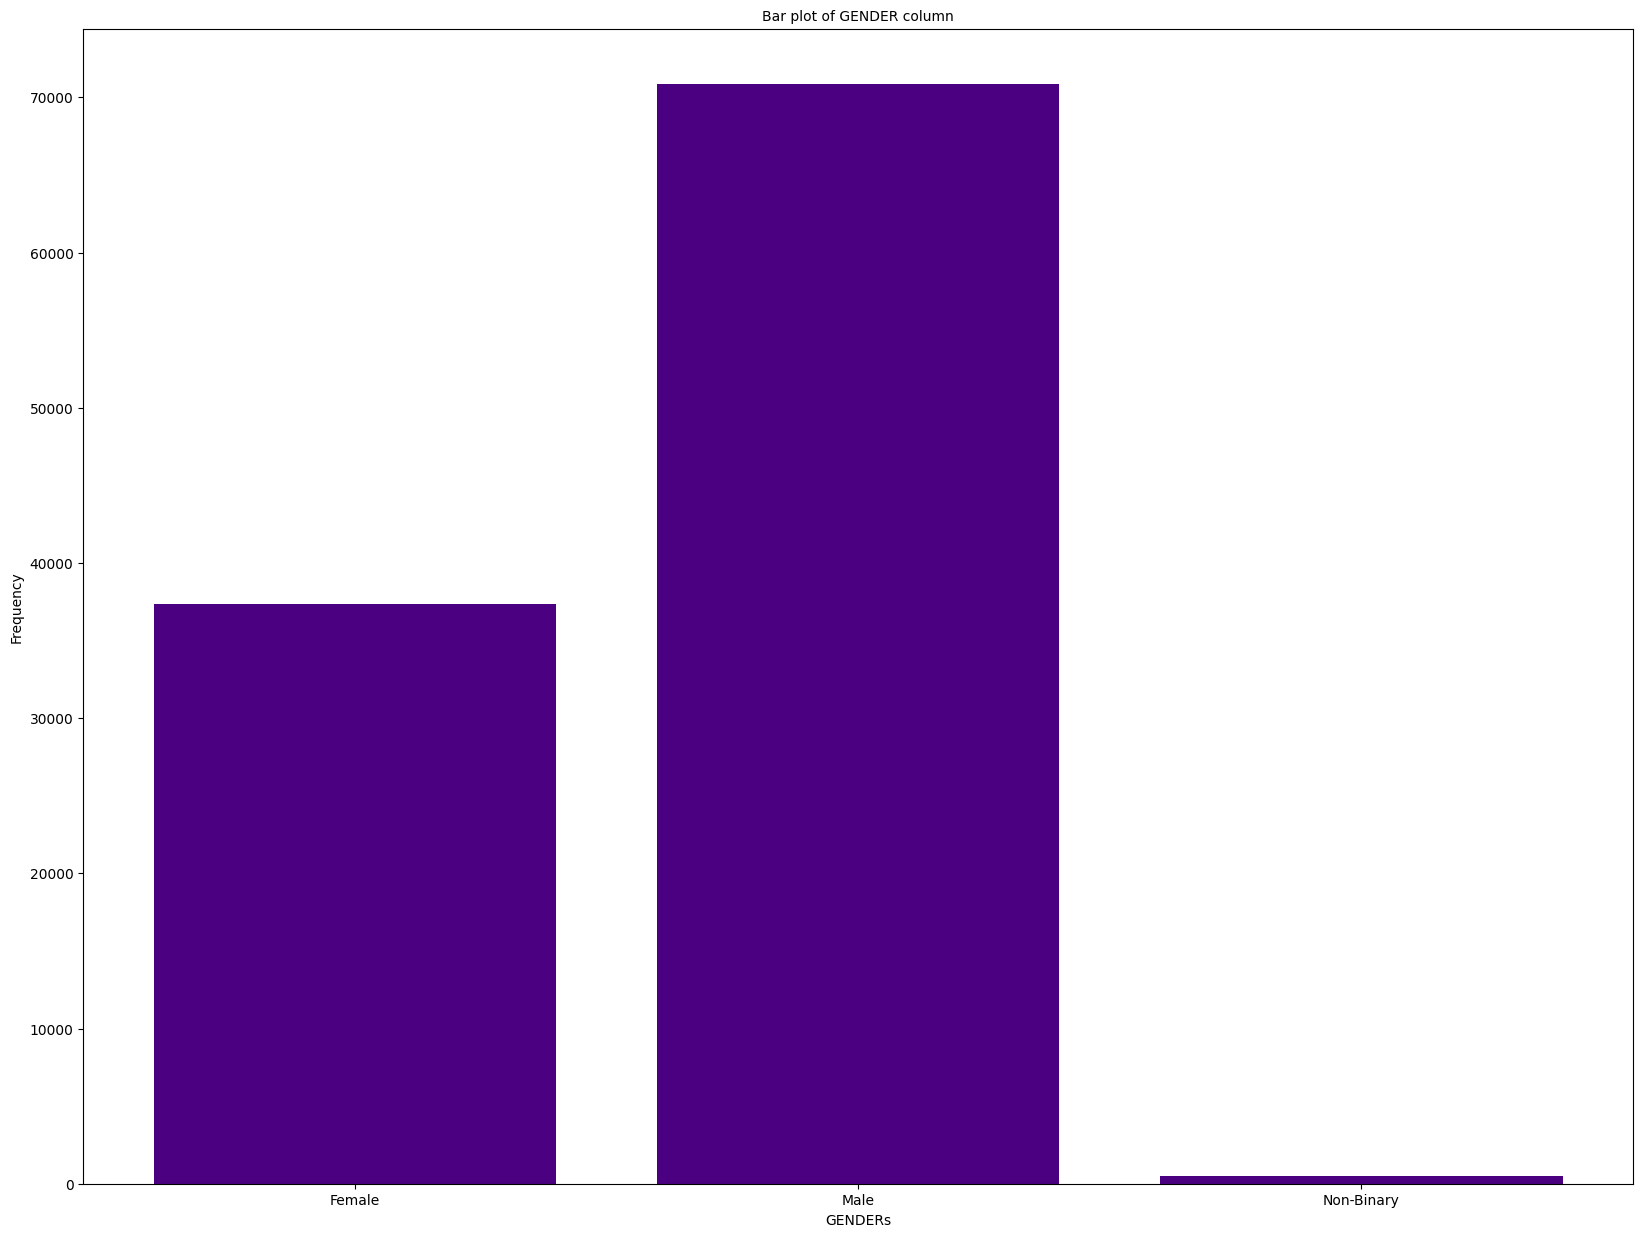

In [ ]:
data = user_df["gender"]
gender_names, gender_counts = np.unique(data, return_counts=True)
col = 'gender'
plt.figure(figsize=(20, 15))
plt.bar(gender_names, gender_counts, color='indigo')
plt.xticks(rotation=0)
plt.title(f'Bar plot of {col.upper()} column',fontsize=10)
plt.xlabel(f'{col.upper()}s',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
# Saving the figure in local memory
plt.savefig('/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/gender_plot.png')

The  above visualization illustrates gender distribution among anime viewers, indicating that males comprise the largest demographic with approximately 70,000 viewers, followed by females with around 37,000 viewers, and non-binary individuals representing the smallest group with roughly 100 viewers.

2. Age group that watches Anime :

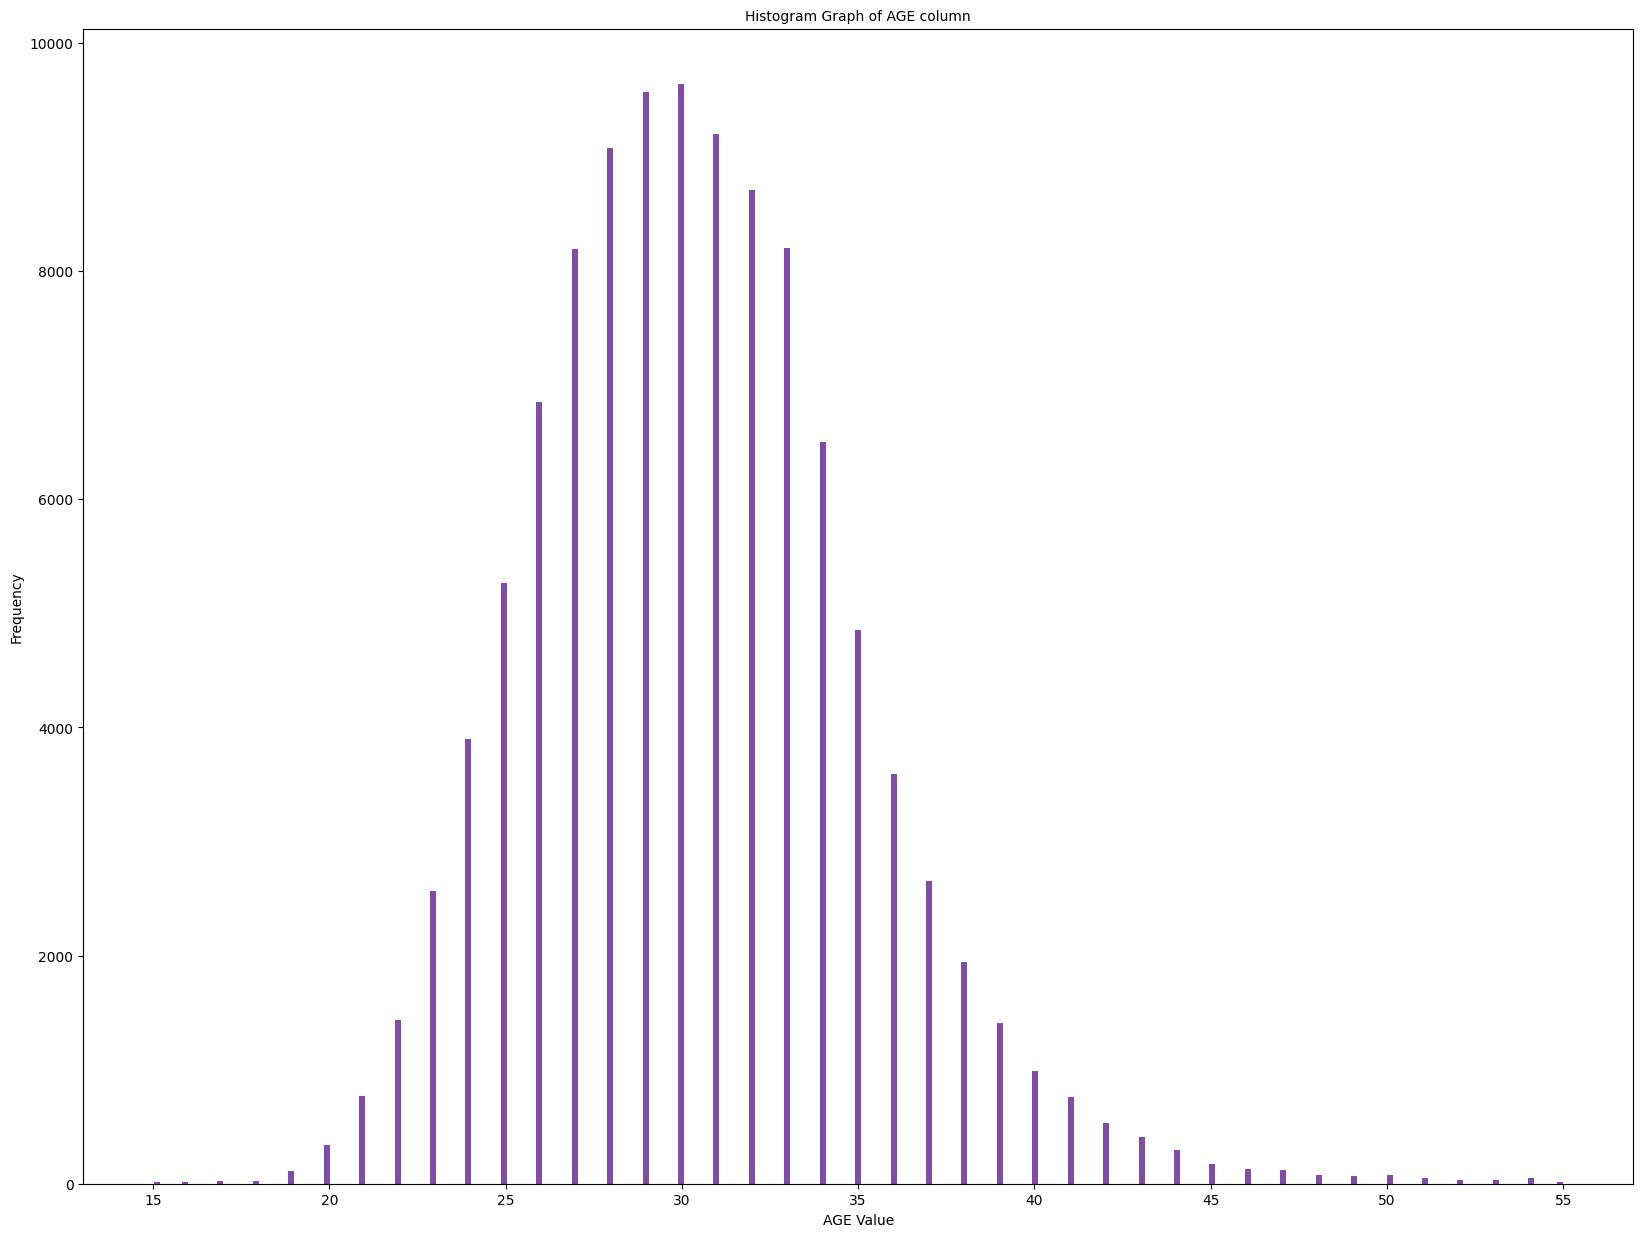

In [ ]:
data = user_df['age']
col = 'age'
plt.figure(figsize=(20, 15))
plt.hist(data, bins=hist_optimize_bins(data), alpha=0.7, rwidth=0.85, color='indigo')
plt.xticks(rotation=0)
plt.title('Histogram Graph of '+col.upper()+' column',fontsize=10)
plt.xlabel(col.upper()+' Value',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
# Saving the figure in local memory
plt.savefig('/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/age_plot.png')

The histogram analysis reveals that the majority of anime viewers fall within the age range of 25 to 35, with a broader spectrum beginning at approximately 18 and extending to around 35. Subsequently, there is a decline in viewership beyond the age of 45, particularly among individuals aged 45 to 55, indicating a decrease in anime consumption within this demographic.

Anime Dataset Visualization

1. Genre View -

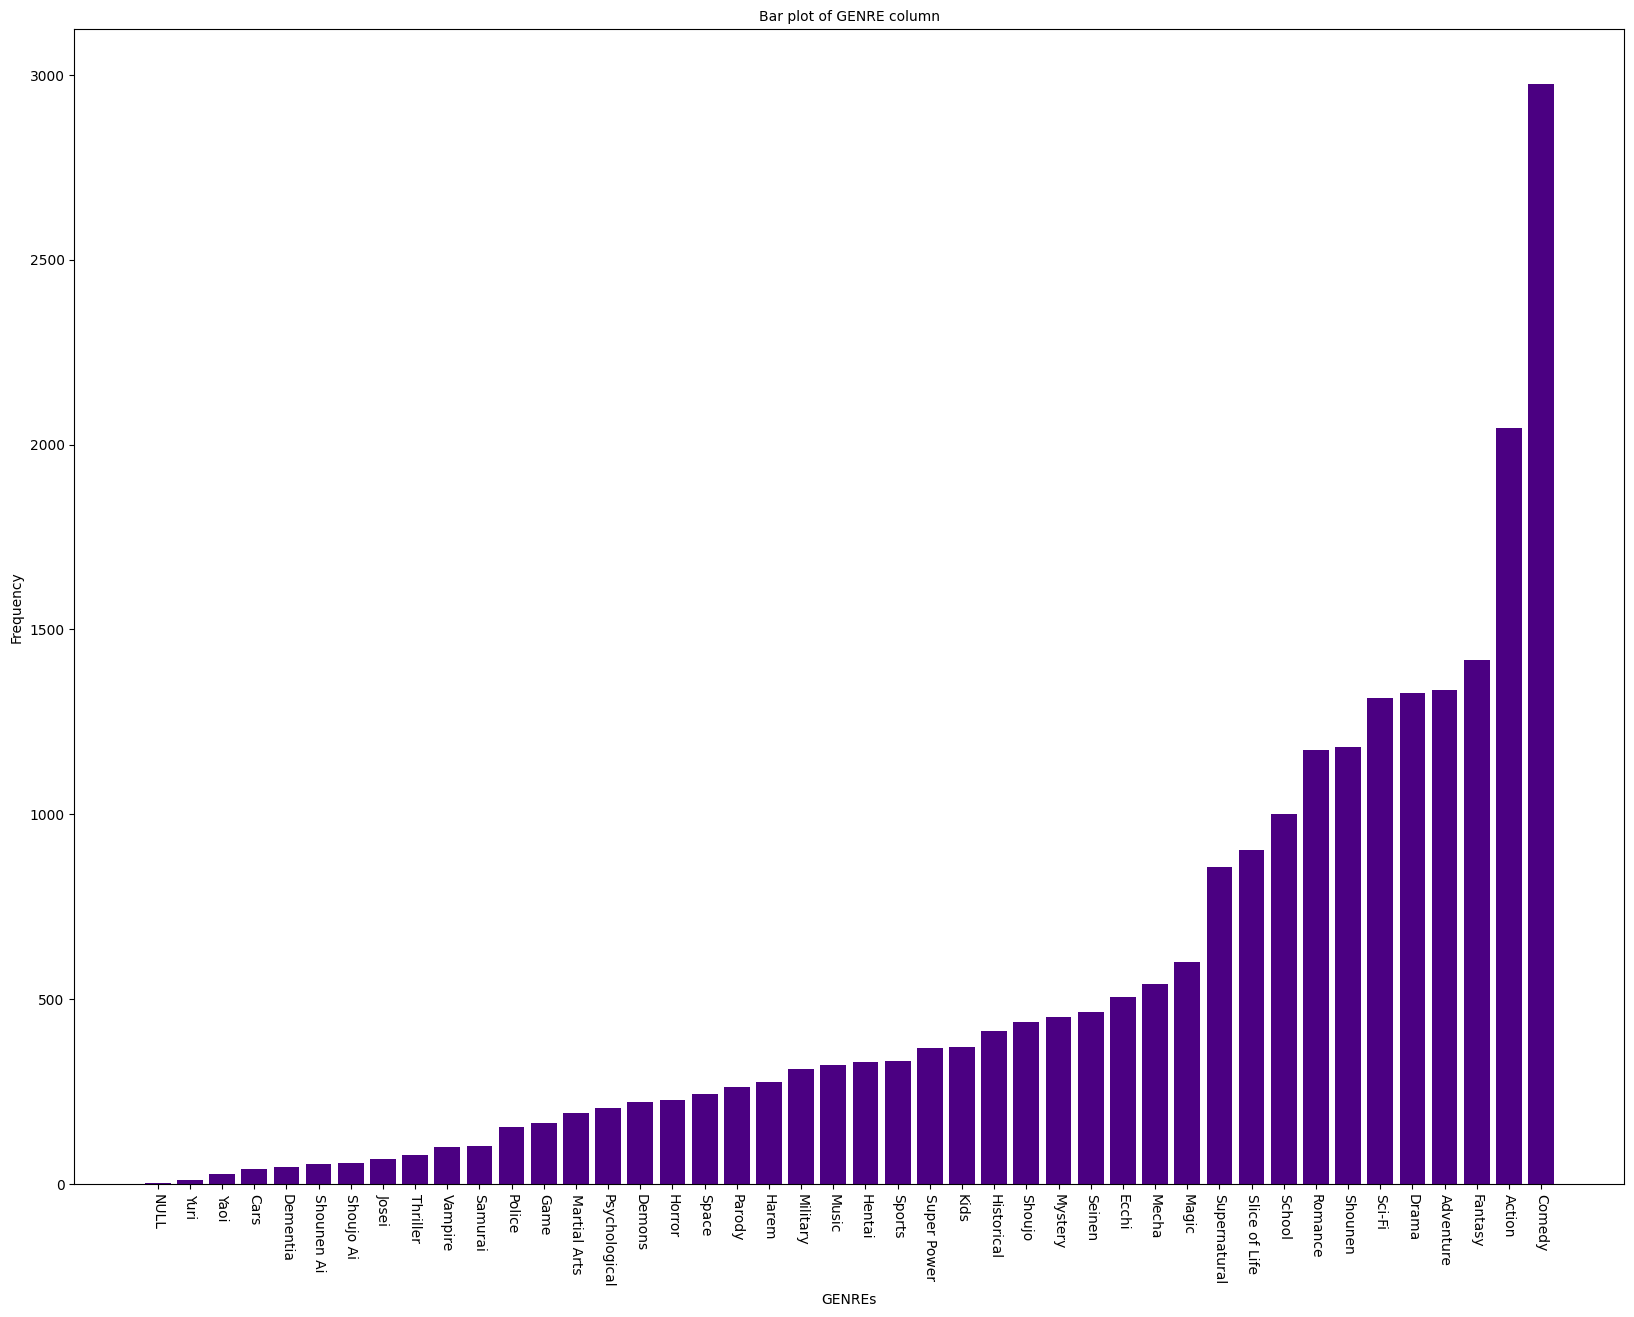

In [ ]:
data = []
for genre in genres:
    data.append(anime_df[genre].sum())
data = dict(zip(genres, data))
data = dict(sorted(data.items(), key=lambda item:item[1]))
col = 'genre'
plt.figure(figsize=(20, 15))
plt.bar(data.keys(), data.values(), color='indigo')
plt.xticks(rotation=-90)
plt.title(f'Bar plot of {col.upper()} column',fontsize=10)
plt.xlabel(f'{col.upper()}s',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
# Saving the figure in local memory
plt.savefig('/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/genre_plot.png')

Based on the graph, it is evident that the Comedy genre stands out as the most prevalent and viewed category of anime, totaling approximately 3000 instances. Following closely is the Action genre, with around 2000 entries. Additionally, genres such as Fantasy, Adventure, Drama, and Sci-Fi exhibit comparable levels of popularity, each accounting for approximately 1400 anime productions. Conversely, other genres display a declining trend in creation, suggesting a lower prevalence in the dataset. In summary, Comedy emerges as the dominant genre in terms of creation frequency within the dataset.

2. Year of release (Animes)

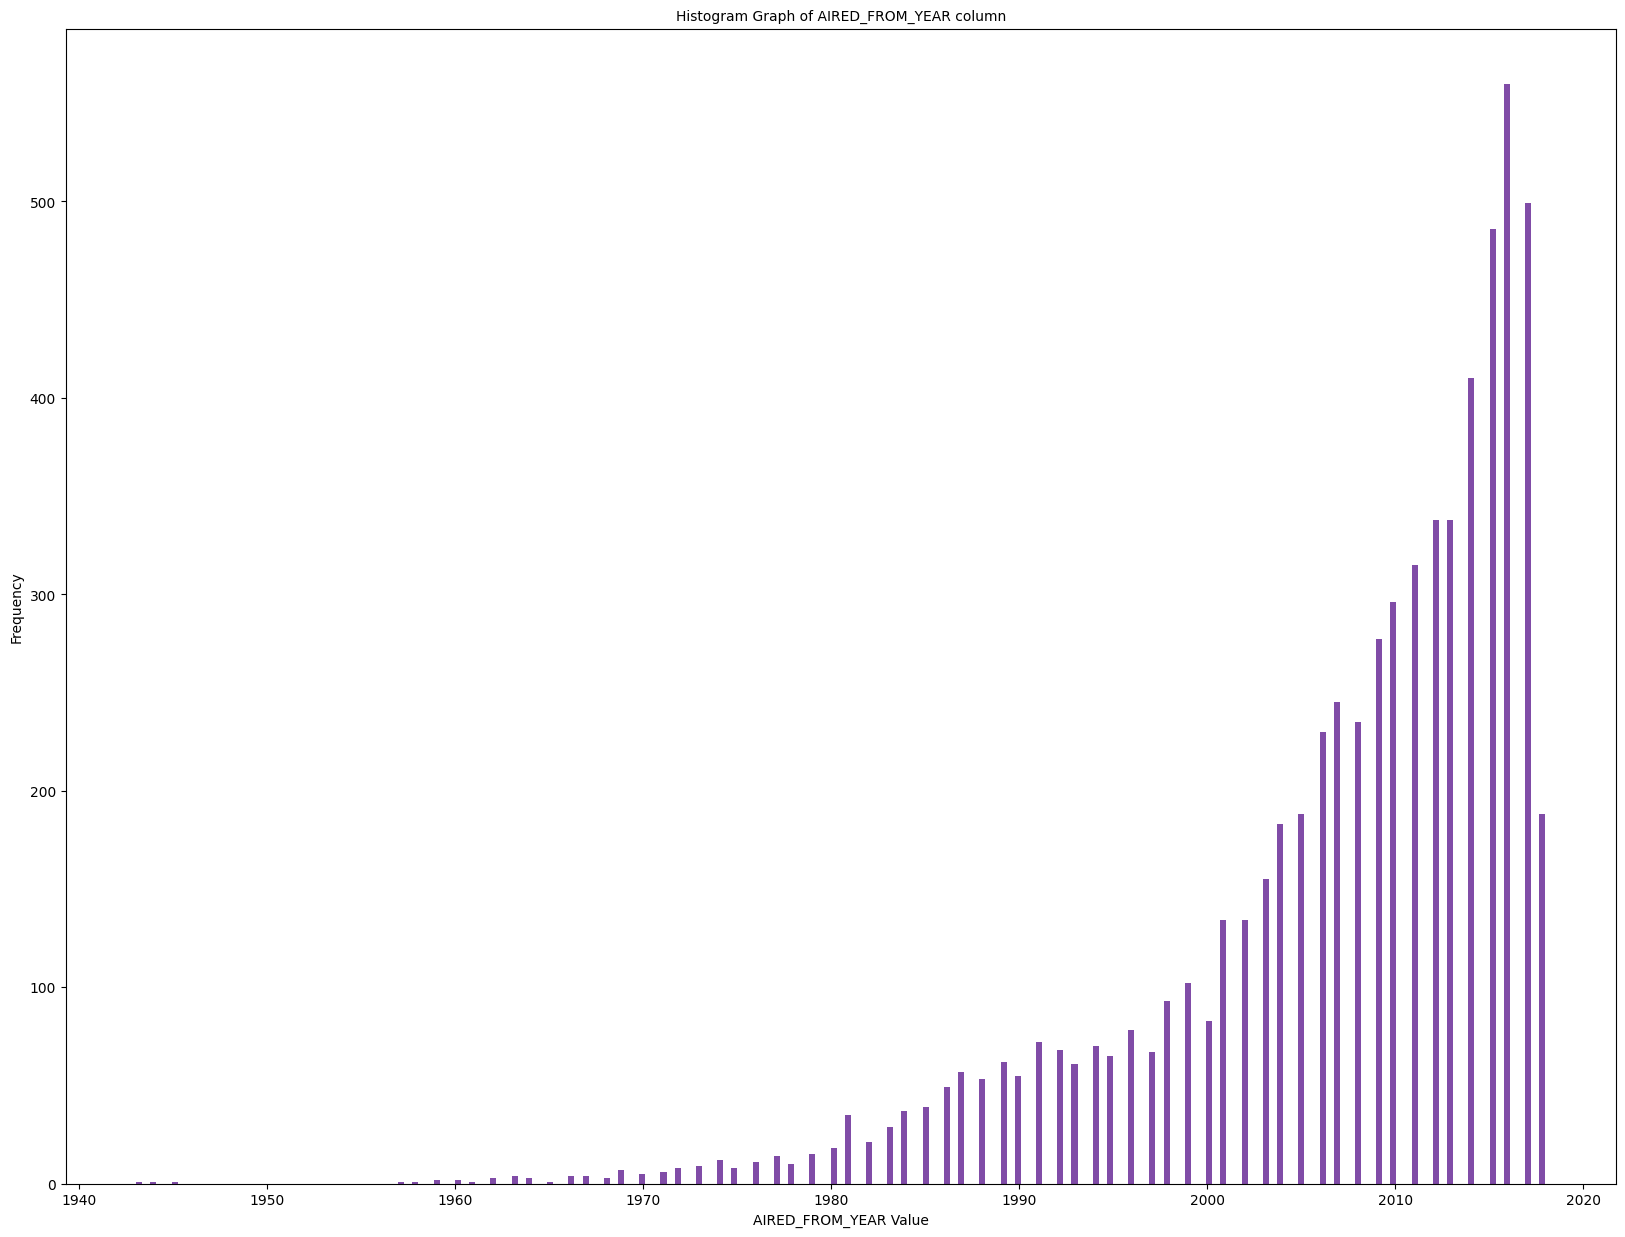

In [ ]:
data = anime_df['aired_from_year']
col = 'aired_from_year'
plt.figure(figsize=(20, 15))
plt.hist(data, bins=hist_optimize_bins(data), alpha=0.7, rwidth=0.85, color='indigo')
plt.xticks(rotation=0)
plt.title('Histogram Graph of '+col.upper()+' column',fontsize=10)
plt.xlabel(col.upper()+' Value',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
# Saving the figure in local memory
plt.savefig('/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/year_of_release_plot.png')

The graph illustrates the trend of anime releases spanning several decades, revealing a notable surge in popularity over recent years compared to its modest beginnings. Initial anime productions were limited, with minimal activity recorded in the mid-1940s. However, a significant uptick occurred from the 1960s onward, gradually increasing to around 100 releases by the early 2000s. Subsequent years witnessed a remarkable annual rise, with the count escalating to approximately 300 by 2010, and surpassing 400 by 2015. Notably, the period between 2017 and 2019 exhibited a substantial spike, exceeding 500 releases. Although the dataset concludes at this juncture, it suggests a consistent upward trajectory in anime creation over time. It is reasonable to infer that this trend likely persisted beyond 2019, indicating a continued rise in anime production leading up to 2024.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


----------------------------------------- Recommendation Engine -----------------------------------------

In [4]:
#%config IPCompleter.greedy=True
import findspark
findspark.init()

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.mllib.recommendation import ALS
from pyspark.mllib.recommendation import Rating

In [5]:
conf = SparkConf().set("spark.ui.port", "4050") \
                  .setAppName('Recommendation System with Spark') \
                  .setMaster('local')
sc = SparkContext(conf=conf)
#SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()

Split Data into Train and Test set

In [ ]:
rating = sc.textFile("/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/updated_ratings_cleaned.csv")
header = rating.first() #extract header
rating = rating.filter(lambda row: row != header)   #filter out header
rating.take(3)

In [ ]:
trainingRatings, testRatings = rating.randomSplit([0.7, 0.3])

In [ ]:
trainingData = trainingRatings.map(lambda l: l.split(',')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
trainingData.take(3)

In [ ]:
testData = testRatings.map(lambda l: l.split(',')).map(lambda l: (int(l[0]), int(l[1])))
testData.take(3)

In [ ]:
def calc_mse(test_rating, predict_rating):
    sum=0
    n=len(predict_rating)
    for i in range(0,n):
        difference = test_rating[i]-predict_rating[i]
        squared_difference = difference**2
        sum = sum +squared_difference
    MSE =sum/n
    print("The Mean Square Error is: ", MSE)

In [ ]:
def plot_performance_evaluation_of_model(test_ratings, predict_ratings):
    bars1 = test_ratings[0:5]
    bars2 = predict_ratings[0:5]

    barWidth = 0.3

    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(20,15))
    plt.bar(r1, bars1, width = barWidth, color = 'indigo', edgecolor = 'black', capsize=7, label='Rating')
    plt.bar(r2, bars2, width = barWidth, color = 'teal', edgecolor = 'black', capsize=7, label='Prediction')

    plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
    plt.ylabel('Rating')
    plt.legend()

    plt.show()

The Mean Square Error is:  21.81031479652611


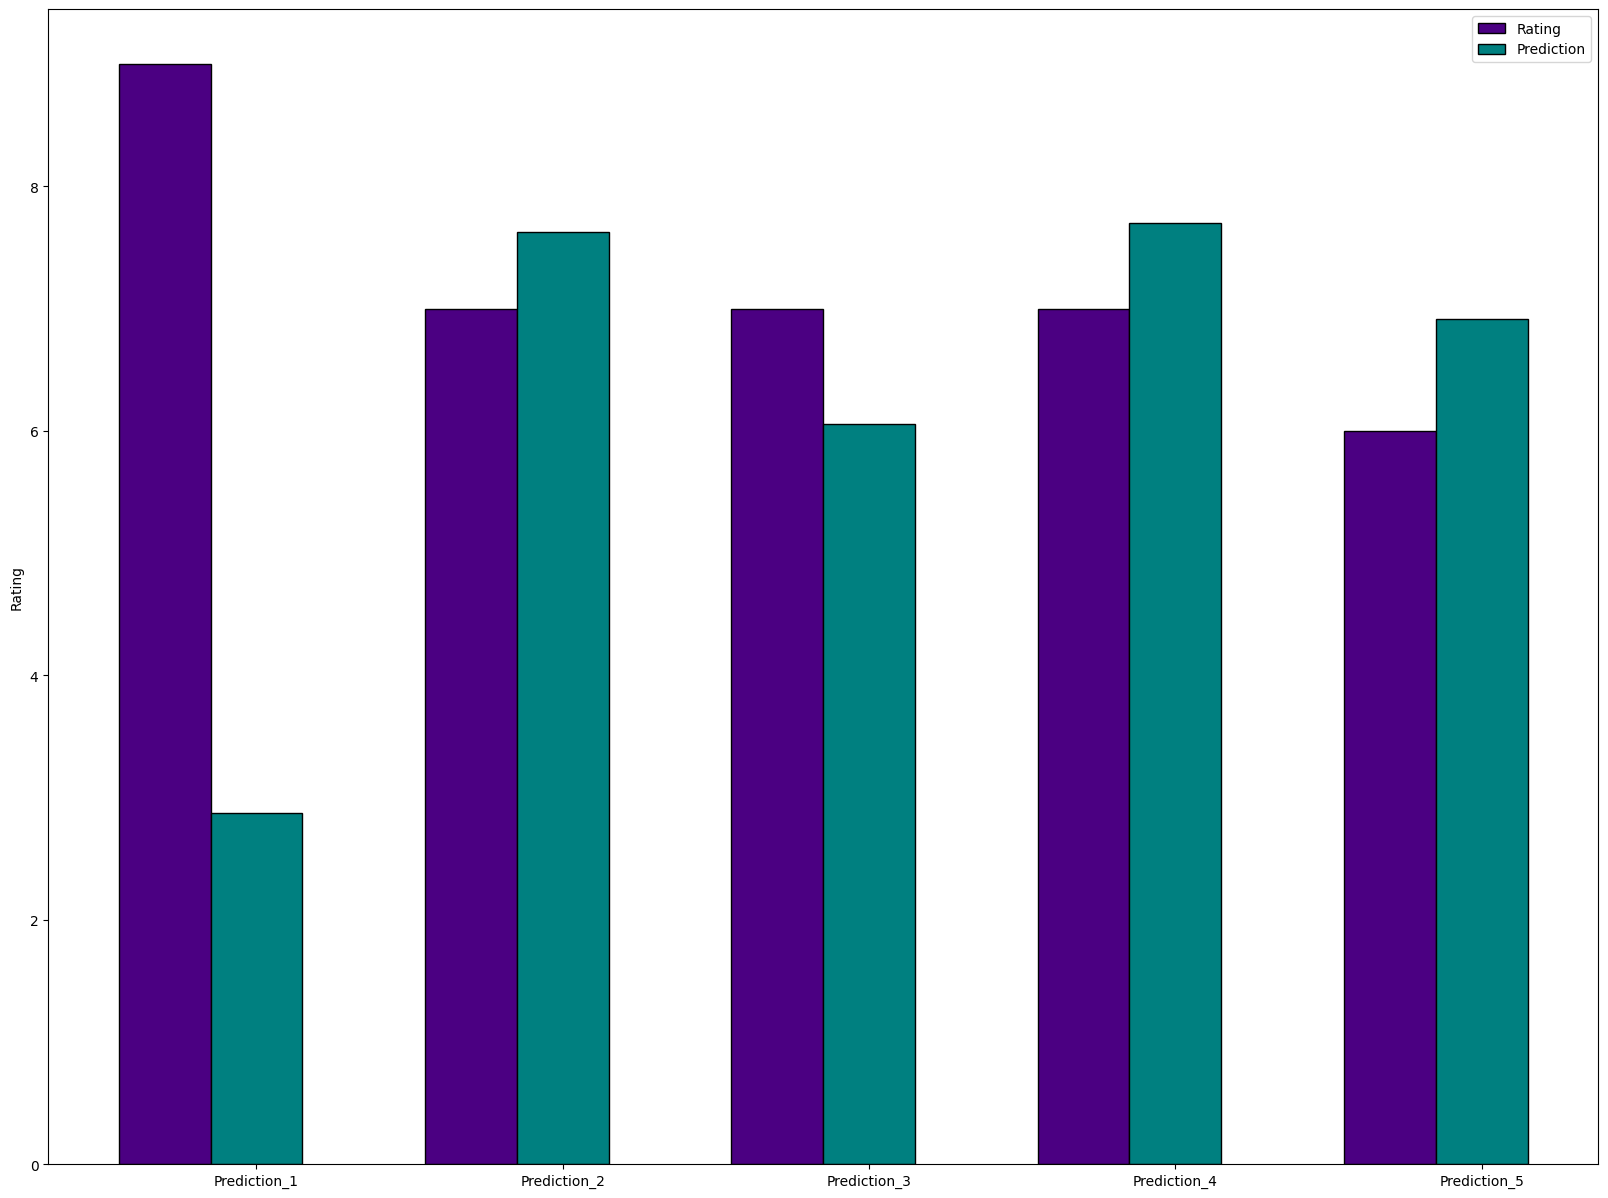

In [ ]:
rank, iter, lambda_ = 10, 10, 0.1
model = ALS.train(trainingData, rank=rank, iterations=iter, lambda_=lambda_, seed=5047)
predictions = model.predictAll(testData)
allPredictRatings=predictions.map(lambda l: float(l[2]))
arr_allPredictRatings=allPredictRatings.collect()
allTestRatings = testRatings.map(lambda l: l.split(',')).map(lambda l: (float(l[2])))
arr_allTestRatings=allTestRatings.collect()
calc_mse(arr_allTestRatings, arr_allPredictRatings)
plot_performance_evaluation_of_model(arr_allTestRatings, arr_allPredictRatings)

The Mean Square Error is:  22.5999927484207


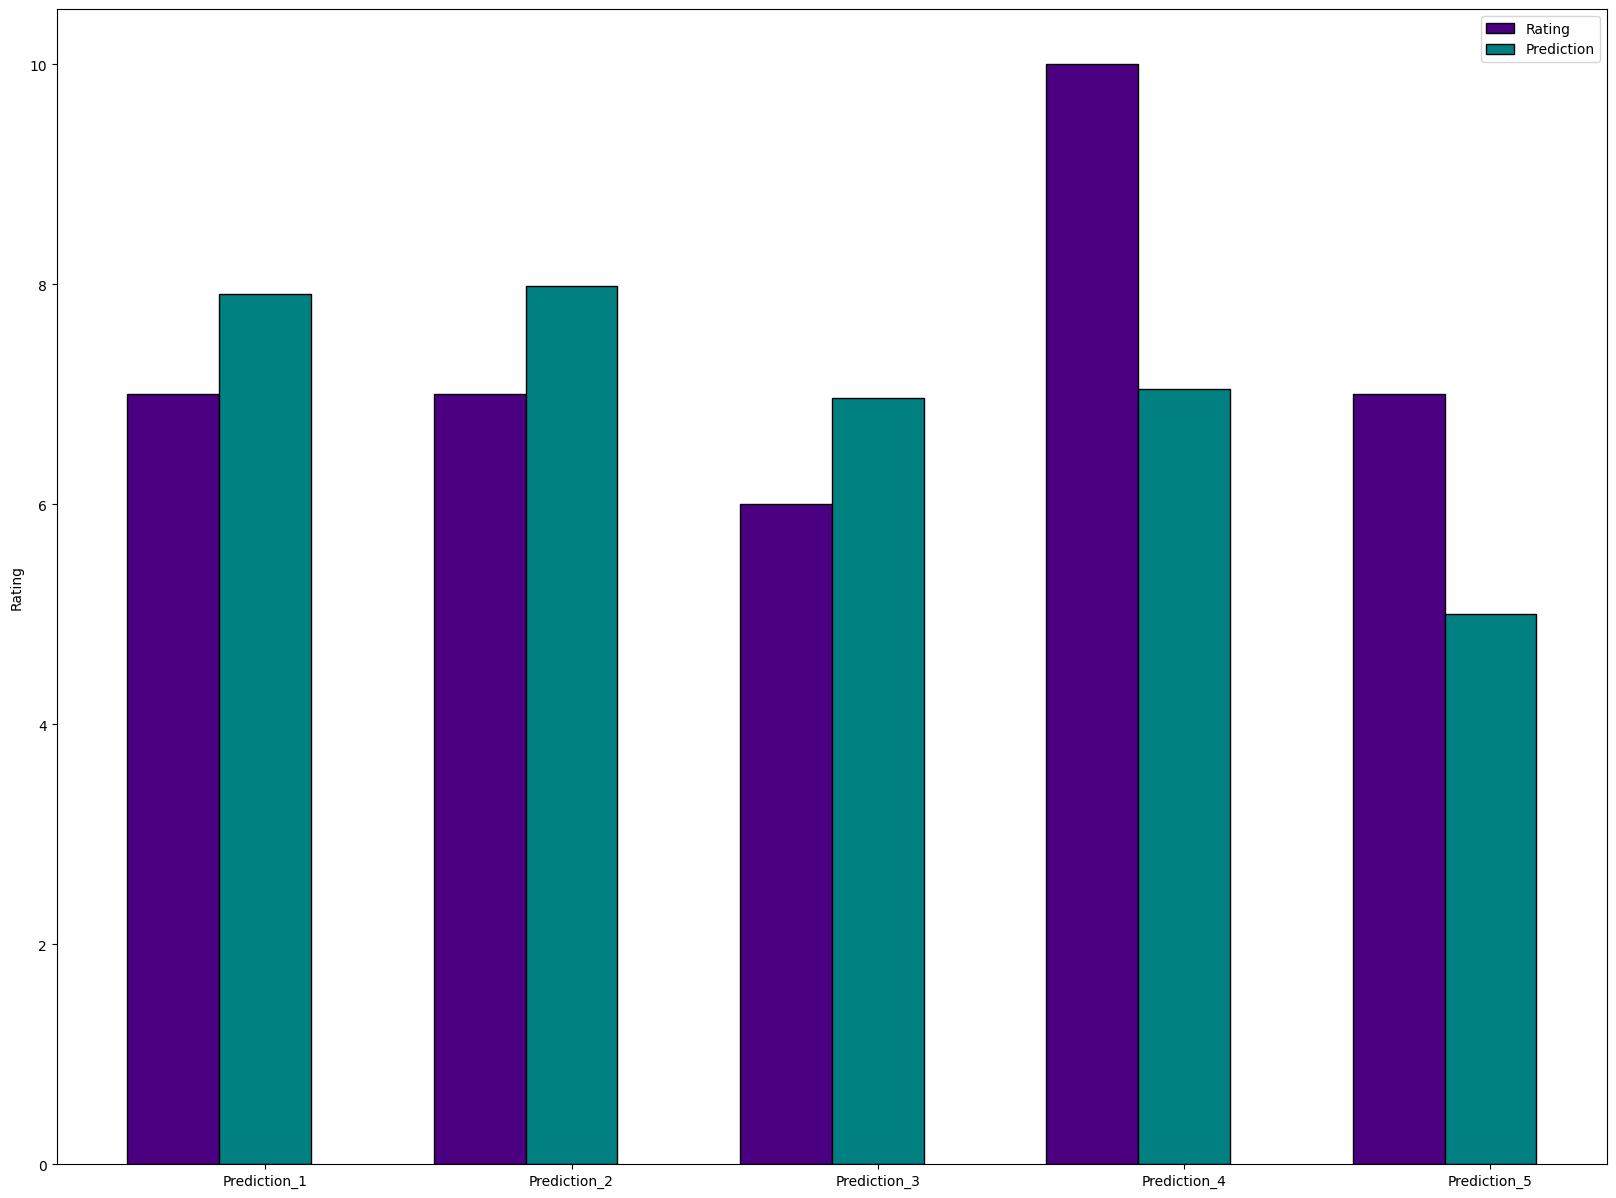

In [ ]:
rank, iter, lambda_ = 10, 10, 0.01
model = ALS.train(trainingData, rank=rank, iterations=iter, lambda_=lambda_, seed=5047)
predictions = model.predictAll(testData)
allPredictRatings=predictions.map(lambda l: float(l[2]))
arr_allPredictRatings=allPredictRatings.collect()
allTestRatings = testRatings.map(lambda l: l.split(',')).map(lambda l: (float(l[2])))
arr_allTestRatings=allTestRatings.collect()
calc_mse(arr_allTestRatings, arr_allPredictRatings)
plot_performance_evaluation_of_model(arr_allTestRatings, arr_allPredictRatings)

The Mean Square Error is:  22.519881004505823


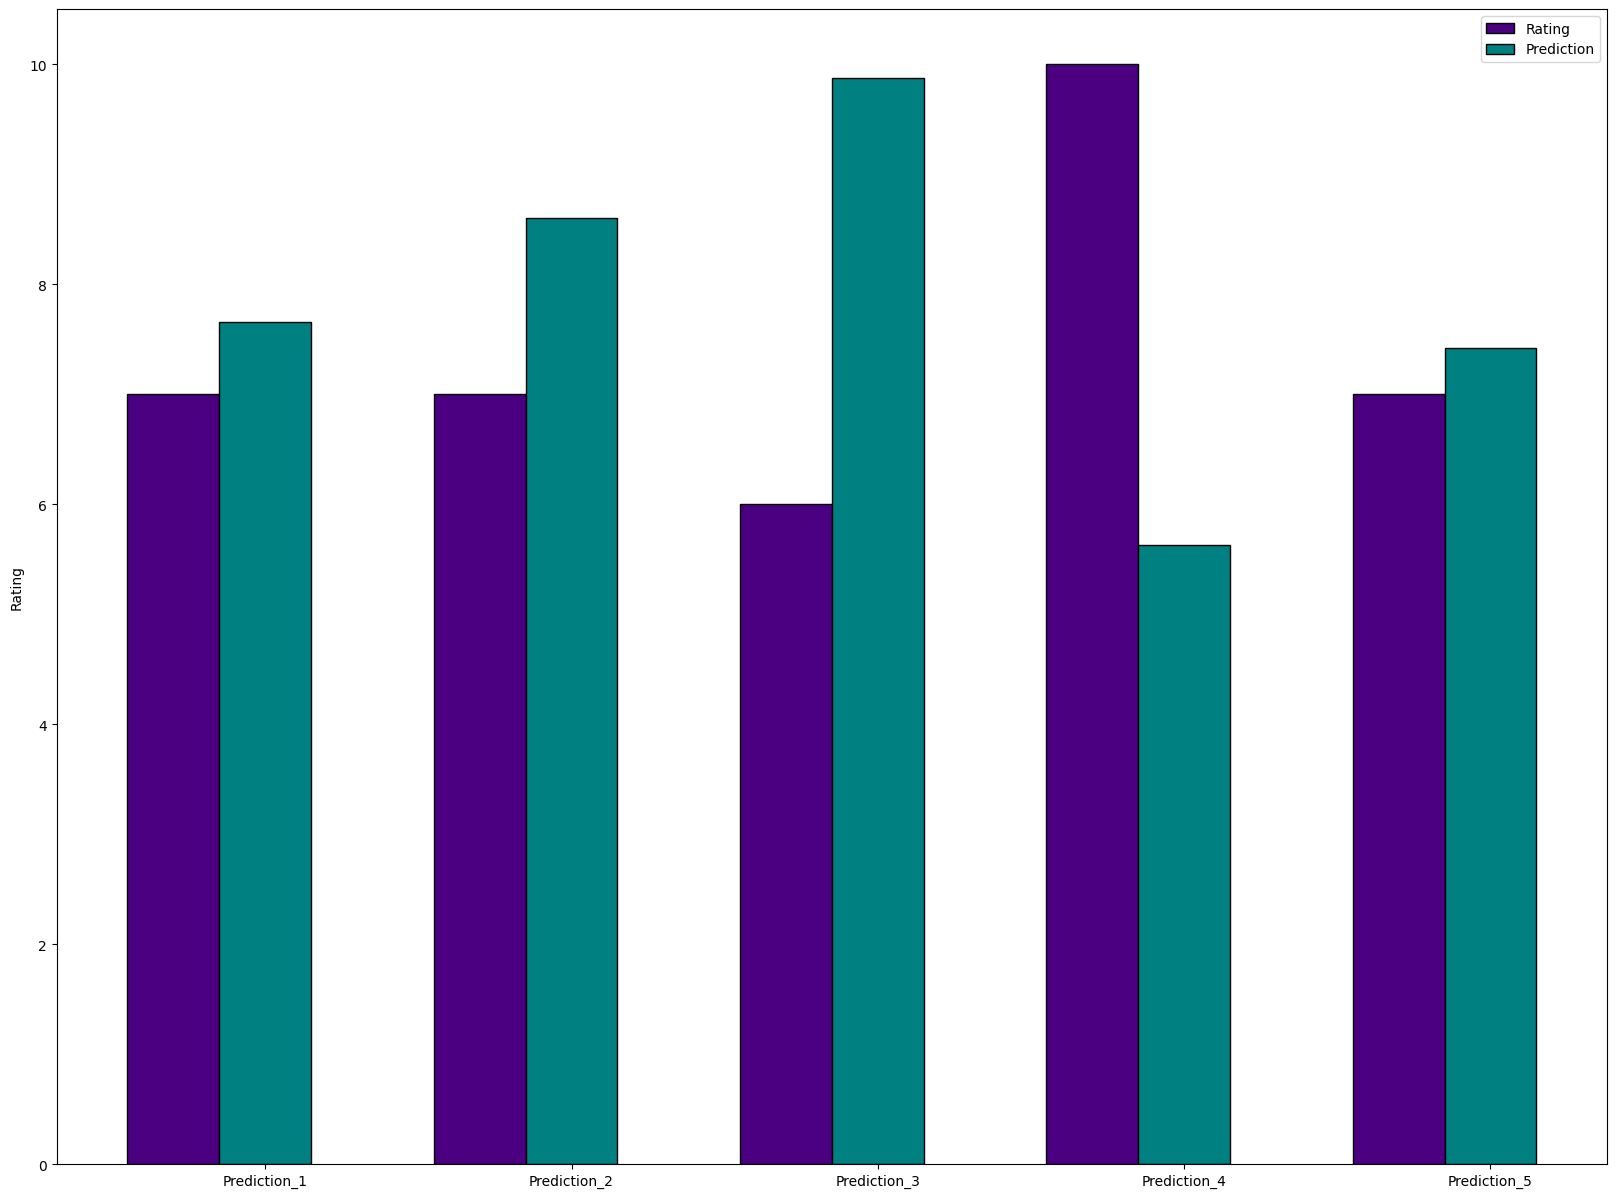

In [ ]:
rank, iter, lambda_ = 50, 10, 0.1
model = ALS.train(trainingData, rank=rank, iterations=iter, lambda_=lambda_, seed=5047)
predictions = model.predictAll(testData)
allPredictRatings=predictions.map(lambda l: float(l[2]))
arr_allPredictRatings=allPredictRatings.collect()
allTestRatings = testRatings.map(lambda l: l.split(',')).map(lambda l: (float(l[2])))
arr_allTestRatings=allTestRatings.collect()
calc_mse(arr_allTestRatings, arr_allPredictRatings)
plot_performance_evaluation_of_model(arr_allTestRatings, arr_allPredictRatings)

The Mean Square Error is:  25.69494168592733


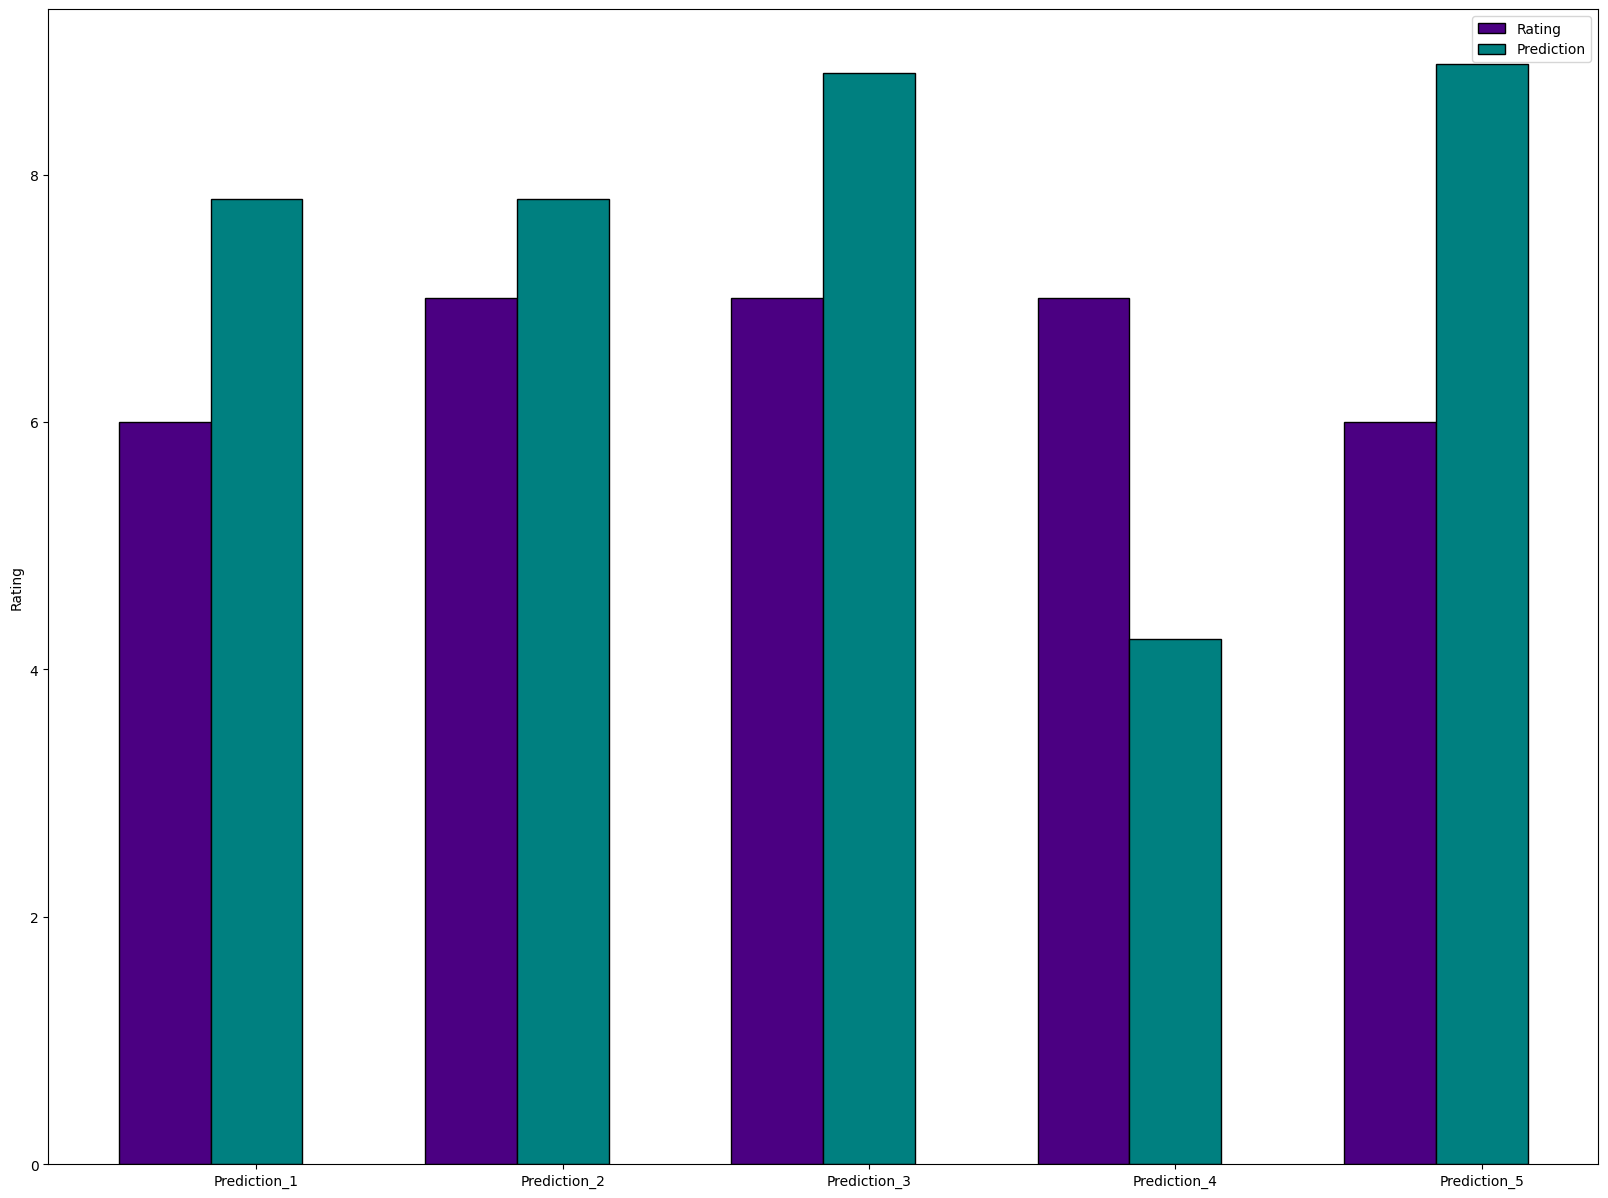

In [ ]:
rank, iter, lambda_ = 50, 10, 0.01
model = ALS.train(trainingData, rank=rank, iterations=iter, lambda_=lambda_, seed=5047)
predictions = model.predictAll(testData)
allPredictRatings=predictions.map(lambda l: float(l[2]))
arr_allPredictRatings=allPredictRatings.collect()
allTestRatings = testRatings.map(lambda l: l.split(',')).map(lambda l: (float(l[2])))
arr_allTestRatings=allTestRatings.collect()
calc_mse(arr_allTestRatings, arr_allPredictRatings)
plot_performance_evaluation_of_model(arr_allTestRatings, arr_allPredictRatings)

The Best Model

In [15]:
rating = sc.textFile("/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/updated_ratings_cleaned.csv")
header = rating.first() #extract header
rating = rating.filter(lambda row: row != header)   #filter out header
rating.take(3)

['2255153,21,9', '2255153,59,7', '2255153,74,7']

In [16]:
rating = rating.map(lambda l: l.split(',')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
rating.take(3)

[Rating(user=2255153, product=21, rating=9.0),
 Rating(user=2255153, product=59, rating=7.0),
 Rating(user=2255153, product=74, rating=7.0)]

In [ ]:
rank, iter, lambda_ = 50, 10, 0.1
model_final = ALS.train(rating, rank=rank, iterations=iter, lambda_=lambda_, seed=5047)

In [ ]:
model_final.userFeatures().count()

108710

In [ ]:
model_final.productFeatures().count()

6668

In [ ]:
predicted_rating = model_final.predict(2485327, 59)
predicted_rating

4.40036151441373

In [ ]:
#pip install matrix-factorization

In [7]:
from pyspark.mllib.recommendation import MatrixFactorizationModel

model_final.save(sc, "/content/drive/MyDrive/Cloud_Computing/model1")


In [8]:
# Load Model
sameModel = MatrixFactorizationModel.load(sc, "/content/drive/MyDrive/Cloud_Computing/model1")

Recommend the K number of animes for same user

In [9]:
userId= 2485327
K=10
top_k_recs = sameModel.recommendProducts(userId,K)
for i in top_k_recs:
    print(i)

Rating(user=2485327, product=5114, rating=8.626901696185769)
Rating(user=2485327, product=28977, rating=8.59947920329657)
Rating(user=2485327, product=9969, rating=8.471378968203277)
Rating(user=2485327, product=15335, rating=8.377934359733882)
Rating(user=2485327, product=11061, rating=8.352191482481317)
Rating(user=2485327, product=34096, rating=8.288050837826896)
Rating(user=2485327, product=15417, rating=8.284163573718828)
Rating(user=2485327, product=918, rating=8.281317715058988)
Rating(user=2485327, product=28851, rating=8.237622764352656)
Rating(user=2485327, product=2904, rating=8.216317217242523)


In [10]:
animes = spark.read.csv("/content/drive/MyDrive/Cloud_Computing/Anime-and-Chill---Recommendation-system/data/updated_anime_cleaned.csv", header=True)
animes = animes.dropna()
animes = animes.rdd

In [11]:
anime_titles = animes.map(lambda line: line[:2]) \
                     .map(lambda x: (int(float(x[0])), x[1])).collectAsMap()

In [12]:
anime_titles

{11013: 'Inu x Boku SS',
 2104: 'Seto no Hanayome',
 5262: 'Shugo Chara!! Doki',
 721: 'Princess Tutu',
 12365: 'Bakuman. 3rd Season',
 6586: 'Yume-iro Pâtissière',
 178: 'Ultra Maniac',
 2787: 'Shakugan no Shana II (Second)',
 4477: 'Nodame Cantabile: Paris-hen',
 853: 'Ouran Koukou Host Club',
 4814: 'Junjou Romantica 2',
 7054: 'Kaichou wa Maid-sama!',
 11123: 'Sekaiichi Hatsukoi 2',
 14227: 'Tonari no Kaibutsu-kun',
 269: 'Bleach',
 59: 'Chobits',
 6045: 'Kimi ni Todoke',
 1735: 'Naruto: Shippuuden',
 210: 'Ranma ½',
 4224: 'Toradora!',
 10030: 'Bakuman. 2nd Season',
 74: 'Gakuen Alice',
 4722: 'Skip Beat!',
 14397: 'Chihayafuru 2',
 1557: 'Shounen Onmyouji',
 10800: 'Chihayafuru',
 3731: 'Itazura na Kiss',
 9513: 'Beelzebub',
 5835: 'Hanasakeru Seishounen',
 9863: 'SKET Dance',
 7817: 'B-gata H-kei',
 966: 'Crayon Shin-chan',
 120: 'Fruits Basket',
 957: 'Saiunkoku Monogatari',
 21: 'One Piece',
 1974: 'Glass no Kamen (2005)',
 857: 'Air Gear',
 1914: 'Saiunkoku Monogatari 2nd Sea

In [17]:
rating = rating.map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))

In [18]:
animes_for_user = rating.keyBy(lambda x: x.user)
animes_for_user.take(10)

[(2255153, Rating(user=2255153, product=21, rating=9.0)),
 (2255153, Rating(user=2255153, product=59, rating=7.0)),
 (2255153, Rating(user=2255153, product=74, rating=7.0)),
 (2255153, Rating(user=2255153, product=120, rating=7.0)),
 (2255153, Rating(user=2255153, product=178, rating=7.0)),
 (2255153, Rating(user=2255153, product=210, rating=7.0)),
 (2255153, Rating(user=2255153, product=232, rating=6.0)),
 (2255153, Rating(user=2255153, product=233, rating=6.0)),
 (2255153, Rating(user=2255153, product=249, rating=8.0)),
 (2255153, Rating(user=2255153, product=269, rating=10.0))]

In [19]:
animes_for_user = rating.keyBy(lambda x: x.user).lookup(2485327)

In [20]:
len(animes_for_user)

3388

In [21]:
animes_for_user.sort(reverse=True,key= lambda x: x.rating)

In [22]:
animes_for_user

[Rating(user=2485327, product=16, rating=10.0),
 Rating(user=2485327, product=392, rating=10.0),
 Rating(user=2485327, product=777, rating=10.0),
 Rating(user=2485327, product=877, rating=10.0),
 Rating(user=2485327, product=918, rating=10.0),
 Rating(user=2485327, product=1535, rating=10.0),
 Rating(user=2485327, product=1575, rating=10.0),
 Rating(user=2485327, product=1604, rating=10.0),
 Rating(user=2485327, product=2904, rating=10.0),
 Rating(user=2485327, product=4081, rating=10.0),
 Rating(user=2485327, product=5114, rating=10.0),
 Rating(user=2485327, product=9969, rating=10.0),
 Rating(user=2485327, product=10087, rating=10.0),
 Rating(user=2485327, product=10408, rating=10.0),
 Rating(user=2485327, product=11061, rating=10.0),
 Rating(user=2485327, product=11741, rating=10.0),
 Rating(user=2485327, product=12531, rating=10.0),
 Rating(user=2485327, product=13601, rating=10.0),
 Rating(user=2485327, product=15335, rating=10.0),
 Rating(user=2485327, product=15417, rating=10.0)

10 animes with the highest ratings for user 2485327

In [23]:
sc.parallelize(animes_for_user[:10])\
.map(lambda rating: (anime_titles[rating.product], rating.rating)).collect()

[('Hachimitsu to Clover', 10.0),
 ('Yuu☆Yuu☆Hakusho', 10.0),
 ('Hellsing Ultimate', 10.0),
 ('Nana', 10.0),
 ('Gintama', 10.0),
 ('Death Note', 10.0),
 ('Code Geass: Hangyaku no Lelouch', 10.0),
 ('Katekyo Hitman Reborn!', 10.0),
 ('Code Geass: Hangyaku no Lelouch R2', 10.0),
 ('Natsume Yuujinchou', 10.0)]

Top 10 recommendations for user 2485327

In [24]:
sc.parallelize(top_k_recs)\
.map(lambda rating: (anime_titles[rating.product], rating.rating))\
.collect()

[('Fullmetal Alchemist: Brotherhood', 8.626901696185769),
 ('Gintama°', 8.59947920329657),
 ('Gintama&#039;', 8.471378968203277),
 ('Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare', 8.377934359733882),
 ('Hunter x Hunter (2011)', 8.352191482481317),
 ('Gintama.', 8.288050837826896),
 ('Gintama&#039;: Enchousen', 8.284163573718828),
 ('Gintama', 8.281317715058988),
 ('Koe no Katachi', 8.237622764352656),
 ('Code Geass: Hangyaku no Lelouch R2', 8.216317217242523)]

Recommend the top-K users for a given product

In [48]:
productID = 1575
K = 10
topKuser= sameModel.recommendUsers(productID,K)
for i in topKuser:
    print(i)

Rating(user=3717201, product=1575, rating=10.97147549543479)
Rating(user=187070, product=1575, rating=10.749039876635175)
Rating(user=37830, product=1575, rating=10.550278224992601)
Rating(user=3535317, product=1575, rating=10.530447624402438)
Rating(user=5330916, product=1575, rating=10.51061715250077)
Rating(user=321224, product=1575, rating=10.488462866295487)
Rating(user=2528591, product=1575, rating=10.48178302640121)
Rating(user=3458229, product=1575, rating=10.457189223907594)
Rating(user=6493369, product=1575, rating=10.452934642568238)
Rating(user=1396673, product=1575, rating=10.439371453043965)


In [57]:
IDs_with_users = {v: k for k, v in users_with_IDs.items()}

Top 10 users for anime 1575

In [58]:
sc.parallelize(topKuser).map(lambda rating: (IDs_with_users[rating.user], rating.user)).collect()

[('OrangeJP', 3717201),
 ('Blutsauger', 187070),
 ('Bleach2903', 37830),
 ('NoFear94', 3535317),
 ('animangafreak_ZX', 5330916),
 ('mangafreakZX', 321224),
 ('Mikura-san', 2528591),
 ('serialbruno', 3458229),
 ('Z3R0215', 6493369),
 ('Deodatus', 1396673)]

################################################

COSINE SIMILARITY

################################################

In [59]:
def cosineSimilarity(item_id,a,b):
    dot=np.dot(a,b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos= dot/ (norma*normb)
    return item_id,cos

In [60]:
item_id=1575
item_vector= sameModel.productFeatures().lookup(item_id)[0]
item_vector

array('d', [0.15883375704288483, -0.698796808719635, -0.8049314022064209, 0.10919439792633057, -0.07398004084825516, 0.5741266012191772, -0.33215516805648804, 0.3011438548564911, 0.01716277003288269, -0.22018122673034668, -0.15839120745658875, 0.6992636919021606, 0.3495730757713318, -0.02836708351969719, -0.027380524203181267, -0.5357752442359924, 0.007771502714604139, 0.6058624386787415, -0.1636592298746109, -0.01207504328340292, 0.9640011191368103, 0.1094481572508812, -0.284531831741333, -0.4592493176460266, -0.4400211274623871, -0.10222360491752625, 0.5133348703384399, -0.1572549194097519, 0.1691494733095169, 0.37693414092063904, 0.6724147200584412, -0.06618832796812057, -0.739392876625061, -0.09147699177265167, 0.2870532274246216, 0.2264859676361084, -0.27157795429229736, -0.170604407787323, 0.15405525267124176, -1.0361164808273315, -0.35963383316993713, -0.16145598888397217, -0.597286581993103, 0.28701266646385193, -0.3011743724346161, 0.10875290632247925, 0.28660741448402405, -0.

In [61]:
anime_titles[item_id]

'Code Geass: Hangyaku no Lelouch'

In [62]:
cosineSimilarity(item_id,item_vector,item_vector)

(1575, 1.0)

In [65]:
sims= sameModel.productFeatures().map(lambda data: cosineSimilarity(data[0],data[1],item_vector))
top_10_animes = sims.top(10,key=lambda x:x[1])
top_10_animes

[(1575, 1.0),
 (2904, 0.9923430325976976),
 (1535, 0.9719622480348132),
 (5114, 0.9680251649796648),
 (28701, 0.9662402451967902),
 (10030, 0.9660173142653385),
 (11741, 0.9632803279587722),
 (73, 0.9624527250138424),
 (9253, 0.961932713674073),
 (22535, 0.9617782328657138)]

In [66]:
top_10_animes_titles = [anime_titles[a[0]] for a in top_10_animes]
top_10_animes_titles

['Code Geass: Hangyaku no Lelouch',
 'Code Geass: Hangyaku no Lelouch R2',
 'Death Note',
 'Fullmetal Alchemist: Brotherhood',
 'Fate/stay night: Unlimited Blade Works 2nd Season',
 'Bakuman. 2nd Season',
 'Fate/Zero 2nd Season',
 'Full Metal Panic! The Second Raid',
 'Steins;Gate',
 'Kiseijuu: Sei no Kakuritsu']